In [1]:
import numpy as np
import pandas as pd

import time
import gym

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tqdm import tqdm
import random

import torch.nn.functional as F
import torch 
from torch import nn
import torch.optim as optim
import torchvision.transforms as T
from PIL import Image
from collections import deque

import time

In [2]:
from mario2 import MyMarioEnvironment2

In [3]:
class DQN_FC(nn.Module):
    def __init__(self, i, o):
        super(DQN_FC, self).__init__()
        self.fc1 = nn.Linear(in_features=i, out_features=8)
        self.fc2 = nn.Linear(in_features=8, out_features=8)
        self.fc3 = nn.Linear(in_features=8, out_features=o)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x    

In [4]:
class DQN_CNN(nn.Module):
    def __init__(self, h, w, o):
        super(DQN_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32, kernel_size=4, stride=2)
        # print(self.conv_output_shape(h,8,4,0,1))
        out_conv_h = self.conv_output_shape(self.conv_output_shape(h,8,4,0,1),4,2,0,1)
        out_conv_w = self.conv_output_shape(self.conv_output_shape(w,8,4,0,1),4,2,0,1)
        self.fc = nn.Linear(in_features=out_conv_h*out_conv_w*32, out_features=o)
        # print(h,w, out_conv_h,out_conv_w)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.relu(self.conv1(x))
        # print("c1",x.shape)
        x = self.relu(self.conv2(x))
        # print("c2",x.shape)
        x = self.sigmoid(self.fc(self.flatten(x)))
        return x
    
    def conv_output_shape(self, size, kernel_size=1, stride=1, pad=0, dilation=1):
        from math import floor
        if type(kernel_size) is not tuple:
            kernel_size = (kernel_size, kernel_size)
        out = floor( ((size + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )// stride) + 1)
        return out

In [24]:
class GridVanillaDQN():
    def __init__(self, env, typ="dense", gamma=0.90, lr=0.001):
      self.env = env
      self.typ = typ
      self.max_episodes = 2500
      self.max_steps = 30
      self.gamma = gamma
      self.epsilon = 1.0
      self.epsilon_min = 0.01
      self.epsilon_decay_lamda = self.epsilon_min**(1/self.max_episodes)
      self.target_update_counter = 0
      self.target_update_frequency = 10
      self.buffer_minibatch_size = 50
      self.replay_buffer_capacity=3000
      self.replay_buffer = deque([],maxlen=self.replay_buffer_capacity)
      self.resize = T.Compose([T.ToPILImage(),
                    T.Resize(84, interpolation=Image.CUBIC),
                    T.Grayscale(),
                    T.ToTensor()])  
      env.reset()
      obs,aud = self.env.reset()
      obs.extend(self.env.reset()[1])
      lenn = len(obs)
#       _, _, self.state_screen_h, self.state_screen_w = self.screen_preprocessor(self.env.render()).shape
      self.state_count = env.observation_space.n
      self.action_count = env.action_space.n
      self.target_dqn = DQN_FC(lenn, self.action_count) if self.typ=="dense" else DQN_CNN(self.state_screen_h,self.state_screen_w,self.action_count)
      self.q_value_dqn = DQN_FC(lenn, self.action_count) if self.typ=="dense" else DQN_CNN(self.state_screen_h,self.state_screen_w,self.action_count)
      # self.rms_optimizer = optim.RMSprop(self.q_value_dqn.parameters())#, lr=0.001)#, weight_decay=0.05)
      # self.loss_func = F.smooth_l1_loss
      self.rms_optimizer = optim.SGD(self.q_value_dqn.parameters(), lr=lr)#optim.RMSprop(self.q_value_dqn.parameters(), lr=0.001)#, weight_decay=0.05)
      self.loss_func = F.mse_loss #F.smooth_l1_loss
      
      self.timestep_list = []
      self.rewards_list = []
      self.epsilon_list = []
      
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.q_value_dqn#.to(self.device)
      self.target_dqn#.to(self.device)

      self.test_max_episodes = 10
      self.test_timestep_list = []
      self.test_rewards_list = []
      self.test_epsilon_list = []
      self.trained_policy_path = "./grid.pth"

    def initialize_buffer(self):
      for i in range(self.replay_buffer_capacity):
        done = False
        while not done:  
            current_action = self.choose_action(torch.as_tensor(current_state, dtype=torch.float))#.to(self.device)
            next_state, curr_reward, done, truncated, info = self.env.step(current_action)

            self.add_to_replay_buffer((current_state, current_action, curr_reward, next_state, done))
            current_state = next_state

    def screen_preprocessor(self,state_screen):
      def crop(variable,tw,th):
         c, h, w = variable.shape
         x1 = int(round((w - tw) / 2.))
         y1 = int(round((h - th) / 2.))
         return variable[:,y1:y1+th,x1:x1+tw]
      state_screen = state_screen.transpose((2,0,1))
      screen_c, screen_h, screen_w = state_screen.shape
      screen = self.resize(torch.from_numpy(state_screen))
      screen = crop(screen, 60, 60)
      screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
      screen = torch.from_numpy(screen)
      return screen.unsqueeze(0)
    
    def choose_action(self, state, test=False):
      random_no = np.random.random()
      if self.epsilon > random_no and not test:
          return np.random.choice(self.env.action_space.n)
      else:
          return torch.argmax(self.q_value_dqn(state)).item()#.to(self.device))
    
    def get_q_value_for_state(self, state):
      q_values = self.q_value_dqn(state)
      return q_values.max(1)[1].view(1, 1)

    def eval(self,load=False, max_ep=10):
      if load:
        self.q_value_dqn.load_state_dict(torch.load(self.trained_policy_path))
      
      self.test_max_episodes = max_ep
      for episode in tqdm(range(0, self.test_max_episodes), unit='episodes'):
        obs, aud = self.env.reset()
        obs.extend(aud)
        obs = torch.tensor(obs,dtype=torch.float)
        done = False
        reward_sum = 0
        steps = 0
        current_state = obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
        while not done:
          tt = time.time()

          current_action = self.choose_action(current_state, test=True)#.to(self.device)
          curr_obs, curr_aud, curr_reward, done, info = self.env.step(self.env.actions[current_action][0])
          curr_obs.extend(curr_aud)
          curr_obs = torch.tensor(curr_obs,dtype=torch.float)
          
          # self.env.render(mode="human", save=True, step=steps)

          reward_sum += curr_reward
          next_state = curr_obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())

          steps +=1
          
          current_state = next_state
          if steps==20 or reward_sum==16:
            done=True
            
        self.test_timestep_list.append(steps)
        self.test_rewards_list.append(reward_sum)


    def train(self):
      current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch = self.get_minibatch_from_replay_buffer()
      curr_q_value_list = self.q_value_dqn(current_state_batch).gather(1, current_action_batch.reshape([self.buffer_minibatch_size,1])) #.to(self.device)).gather(1, current_action_batch)
      next_q_value_list = self.target_dqn(next_state_batch)#.to(self.device))
      next_q_value_list = next_q_value_list.detach()
      exp_q_value_list = []
      for index in range(self.buffer_minibatch_size):
        if current_done_batch[index]:
          exp_q_value_list.append(current_reward_batch[index])
        else:
          exp_q_value_list.append((current_reward_batch[index] + max(next_q_value_list[index]) * self.gamma))

      exp_q_value_list = torch.tensor(exp_q_value_list, dtype=torch.float).unsqueeze(1)#.to(self.device)

      self.rms_optimizer.zero_grad()
      loss = self.loss_func(curr_q_value_list, exp_q_value_list)
      loss.backward()
      for param in self.q_value_dqn.parameters():
          param.grad.data.clamp_(-1, 1)
      self.rms_optimizer.step()

      return loss.item()
      
    def learn(self):
      self.target_dqn.load_state_dict(self.q_value_dqn.state_dict())
      self.target_dqn.eval()
      
      running_loss=0
      loss=0
      self.tm = []
      self.tr = []
      for episode in tqdm(range(0, self.max_episodes), unit='episodes'):
        # with Profiler() as p:
        obs, aud = self.env.reset()
        obs.extend(aud)
        obs = torch.tensor(obs,dtype=torch.float)
        done = False
        reward_sum = 0
        steps = 0
        current_state = obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
        while not done:
            tt = time.time()

            current_action = self.choose_action(current_state)#.to(self.device)
            curr_obs, curr_audio, curr_reward, done, info = self.env.step(self.env.actions[current_action][0])
            curr_obs.extend(curr_audio)
            curr_obs = torch.tensor(curr_obs, dtype=torch.float)

            reward_sum += curr_reward

            next_state = curr_obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())

            self.add_to_replay_buffer((current_state, current_action, curr_reward, next_state, done))
            t = time.time() 

            if len(self.replay_buffer) >= self.buffer_minibatch_size:       
                loss = self.train()
            self.tm.append(time.time()-t)
            steps +=1
            running_loss = loss*self.buffer_minibatch_size
            current_state = next_state

            self.tr.append(time.time()-tt)
            if steps==self.max_steps or reward_sum==16:
                done=True

        self.update_target_net(episode)
            
        self.timestep_list.append(steps)
        self.rewards_list.append(reward_sum)
        self.epsilon_list.append(self.epsilon)
        self.epsilon = max(0.01, self.epsilon*self.epsilon_decay_lamda)
      
        if episode % 100 == 99:
          print(f"Buffer_size: {len(self.replay_buffer)}|Train_time:{sum(self.tm[-100:])/100}| Sub_t:{sum(self.tr[-100:])/100}")
          print(f'[Episode: {episode+1}] - Steps: {sum(self.timestep_list[-100:])/100} | Rewards: {sum(self.rewards_list[-100:])/100} | Epsilon: {self.epsilon} | loss: {running_loss / 10:.3f}')
          running_loss = 0.0
        
    def update_target_net(self, episode):
       if episode % self.target_update_frequency == self.target_update_frequency-1:   
          self.target_dqn.load_state_dict(self.q_value_dqn.state_dict())
    
    def get_minibatch_from_replay_buffer(self):
      exp_batch = random.sample(self.replay_buffer, self.buffer_minibatch_size)
      current_state_batch = torch.cat(tuple([exp[0] for exp in exp_batch]),dim=0)
      current_action_batch = torch.as_tensor([exp[1] for exp in exp_batch])
      next_state_batch = torch.cat(tuple([exp[3] for exp in exp_batch]),dim=0)
      current_reward_batch = torch.tensor(tuple([exp[2] for exp in exp_batch]))#.to(self.device)
      current_done_batch = torch.tensor(tuple([exp[4] for exp in exp_batch]))#.to(self.device)
      return current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch
    
    def add_to_replay_buffer(self, experience):
       self.replay_buffer.append(experience)

Hyper Parameter Tuning

In [30]:
env = MyMarioEnvironment2(environment_type = 'deterministic')

a = GridVanillaDQN(env, gamma=0.999, lr=0.001)
a.learn()
rewardSD_g1 = a.rewards_list

env = MyMarioEnvironment2(environment_type = 'deterministic')
a = GridVanillaDQN(env, gamma=0.990, lr=0.001)
a.learn()
rewardSD_g2 = a.rewards_list

env = MyMarioEnvironment2(environment_type = 'deterministic')
a = GridVanillaDQN(env, gamma=0.90, lr=0.001)
a.learn()
rewardSD_g3 = a.rewards_list

  4%|▍         | 101/2500 [00:22<07:51,  5.09episodes/s]

Buffer_size: 2941|Train_time:0.0056912899017333984| Sub_t:0.0062348699569702145
[Episode: 100] - Steps: 29.41 | Rewards: -5.73 | Epsilon: 0.8317637711026726 | loss: 2.045


  8%|▊         | 201/2500 [00:43<06:37,  5.78episodes/s]

Buffer_size: 3000|Train_time:0.00493255615234375| Sub_t:0.005454328060150147
[Episode: 200] - Steps: 29.97 | Rewards: -3.62 | Epsilon: 0.691830970918939 | loss: 0.493


 12%|█▏        | 301/2500 [00:57<04:53,  7.50episodes/s]

Buffer_size: 3000|Train_time:0.004094226360321045| Sub_t:0.004527158737182617
[Episode: 300] - Steps: 30.0 | Rewards: -2.67 | Epsilon: 0.5754399373371608 | loss: 0.697


 16%|█▌        | 401/2500 [01:11<04:14,  8.25episodes/s]

Buffer_size: 3000|Train_time:0.003394930362701416| Sub_t:0.0037639760971069336
[Episode: 400] - Steps: 29.84 | Rewards: -1.97 | Epsilon: 0.47863009232264275 | loss: 0.231


 20%|██        | 501/2500 [01:22<03:05, 10.80episodes/s]

Buffer_size: 3000|Train_time:0.003295111656188965| Sub_t:0.003650193214416504
[Episode: 500] - Steps: 27.86 | Rewards: 1.48 | Epsilon: 0.3981071705535017 | loss: 16.080


 24%|██▍       | 600/2500 [01:33<04:52,  6.49episodes/s]

Buffer_size: 3000|Train_time:0.0047220301628112795| Sub_t:0.005219264030456543
[Episode: 600] - Steps: 25.1 | Rewards: 5.14 | Epsilon: 0.3311311214825956 | loss: 16.487


 28%|██▊       | 701/2500 [01:47<06:16,  4.78episodes/s]

Buffer_size: 3000|Train_time:0.008712644577026368| Sub_t:0.009439480304718018
[Episode: 700] - Steps: 25.52 | Rewards: 5.7 | Epsilon: 0.27542287033382085 | loss: 9.653


 32%|███▏      | 802/2500 [02:00<02:21, 12.04episodes/s]

Buffer_size: 3000|Train_time:0.0057342290878295895| Sub_t:0.006508958339691162
[Episode: 800] - Steps: 19.81 | Rewards: 8.48 | Epsilon: 0.22908676527678132 | loss: 3.914


 36%|███▌      | 902/2500 [02:09<01:16, 20.83episodes/s]

Buffer_size: 3000|Train_time:0.003244287967681885| Sub_t:0.0036444473266601563
[Episode: 900] - Steps: 20.92 | Rewards: 6.63 | Epsilon: 0.19054607179632832 | loss: 0.948


 40%|████      | 1002/2500 [02:17<02:50,  8.76episodes/s]

Buffer_size: 3000|Train_time:0.005505228042602539| Sub_t:0.006077835559844971
[Episode: 1000] - Steps: 21.12 | Rewards: 6.81 | Epsilon: 0.15848931924611465 | loss: 2.188


 44%|████▍     | 1101/2500 [02:31<05:50,  3.99episodes/s]

Buffer_size: 3000|Train_time:0.006993260383605957| Sub_t:0.0077949738502502445
[Episode: 1100] - Steps: 28.91 | Rewards: 0.71 | Epsilon: 0.13182567385564378 | loss: 2.329


 48%|████▊     | 1201/2500 [02:46<02:32,  8.50episodes/s]

Buffer_size: 3000|Train_time:0.00336195707321167| Sub_t:0.003831017017364502
[Episode: 1200] - Steps: 30.0 | Rewards: -1.23 | Epsilon: 0.10964781961432139 | loss: 3.722


 52%|█████▏    | 1301/2500 [02:58<02:23,  8.38episodes/s]

Buffer_size: 3000|Train_time:0.0035024428367614745| Sub_t:0.003944656848907471
[Episode: 1300] - Steps: 30.0 | Rewards: -0.65 | Epsilon: 0.09120108393559365 | loss: 0.083


 56%|█████▌    | 1401/2500 [03:11<02:32,  7.20episodes/s]

Buffer_size: 3000|Train_time:0.00473844051361084| Sub_t:0.005411884784698486
[Episode: 1400] - Steps: 30.0 | Rewards: -0.37 | Epsilon: 0.07585775750292077 | loss: 0.010


 60%|██████    | 1501/2500 [03:24<01:57,  8.51episodes/s]

Buffer_size: 3000|Train_time:0.00341949462890625| Sub_t:0.0038514804840087892
[Episode: 1500] - Steps: 30.0 | Rewards: -0.46 | Epsilon: 0.06309573444802141 | loss: 0.060


 64%|██████▍   | 1601/2500 [03:36<01:46,  8.44episodes/s]

Buffer_size: 3000|Train_time:0.003594515323638916| Sub_t:0.004052062034606934
[Episode: 1600] - Steps: 29.85 | Rewards: -0.98 | Epsilon: 0.052480746024979104 | loss: 0.566


 68%|██████▊   | 1701/2500 [03:48<01:18, 10.18episodes/s]

Buffer_size: 3000|Train_time:0.0034688353538513184| Sub_t:0.004360995292663574
[Episode: 1700] - Steps: 29.46 | Rewards: 0.35 | Epsilon: 0.043651583224018214 | loss: 0.260


 72%|███████▏  | 1801/2500 [04:01<01:25,  8.19episodes/s]

Buffer_size: 3000|Train_time:0.0033939623832702636| Sub_t:0.0038776326179504393
[Episode: 1800] - Steps: 29.67 | Rewards: 0.28 | Epsilon: 0.03630780547701154 | loss: 0.118


 76%|███████▌  | 1901/2500 [04:13<01:10,  8.53episodes/s]

Buffer_size: 3000|Train_time:0.0033341193199157714| Sub_t:0.0037443161010742186
[Episode: 1900] - Steps: 29.92 | Rewards: -0.14 | Epsilon: 0.030199517204021385 | loss: 0.278


 80%|████████  | 2001/2500 [04:26<01:02,  8.03episodes/s]

Buffer_size: 3000|Train_time:0.003587496280670166| Sub_t:0.004048247337341309
[Episode: 2000] - Steps: 30.0 | Rewards: -0.38 | Epsilon: 0.025118864315096866 | loss: 0.299


 84%|████████▍ | 2101/2500 [04:38<00:45,  8.78episodes/s]

Buffer_size: 3000|Train_time:0.003290848731994629| Sub_t:0.003713846206665039
[Episode: 2100] - Steps: 29.34 | Rewards: 0.17 | Epsilon: 0.02089296130854132 | loss: 0.422


 88%|████████▊ | 2201/2500 [04:51<00:35,  8.33episodes/s]

Buffer_size: 3000|Train_time:0.0033667302131652832| Sub_t:0.0038092207908630373
[Episode: 2200] - Steps: 30.0 | Rewards: -0.37 | Epsilon: 0.017378008287494567 | loss: 0.226


 92%|█████████▏| 2300/2500 [05:13<00:36,  5.53episodes/s]

Buffer_size: 3000|Train_time:0.005245561599731445| Sub_t:0.005885691642761231
[Episode: 2300] - Steps: 30.0 | Rewards: -0.15 | Epsilon: 0.014454397707459973 | loss: 0.065


 96%|█████████▌| 2400/2500 [05:38<00:26,  3.74episodes/s]

Buffer_size: 3000|Train_time:0.007833020687103271| Sub_t:0.008847506046295165
[Episode: 2400] - Steps: 30.0 | Rewards: -0.13 | Epsilon: 0.012022644346174735 | loss: 0.072


100%|██████████| 2500/2500 [06:02<00:00,  6.90episodes/s]

Buffer_size: 3000|Train_time:0.007691714763641357| Sub_t:0.010538539886474609
[Episode: 2500] - Steps: 30.0 | Rewards: -0.04 | Epsilon: 0.01000000000000053 | loss: 0.031



  4%|▍         | 101/2500 [00:16<05:50,  6.85episodes/s]

Buffer_size: 2972|Train_time:0.0038265299797058104| Sub_t:0.0042451596260070805
[Episode: 100] - Steps: 29.72 | Rewards: -6.81 | Epsilon: 0.8317637711026726 | loss: 2.264


  8%|▊         | 201/2500 [00:33<06:07,  6.25episodes/s]

Buffer_size: 3000|Train_time:0.005984847545623779| Sub_t:0.006440162658691406
[Episode: 200] - Steps: 29.92 | Rewards: -4.72 | Epsilon: 0.691830970918939 | loss: 2.214


 12%|█▏        | 301/2500 [00:45<04:13,  8.68episodes/s]

Buffer_size: 3000|Train_time:0.0033980536460876463| Sub_t:0.0037572026252746583
[Episode: 300] - Steps: 30.0 | Rewards: -1.66 | Epsilon: 0.5754399373371608 | loss: 0.515


 16%|█▌        | 401/2500 [00:57<03:58,  8.81episodes/s]

Buffer_size: 3000|Train_time:0.003317253589630127| Sub_t:0.003675680160522461
[Episode: 400] - Steps: 30.0 | Rewards: -1.27 | Epsilon: 0.47863009232264275 | loss: 0.579


 20%|██        | 501/2500 [01:10<04:11,  7.94episodes/s]

Buffer_size: 3000|Train_time:0.003330583572387695| Sub_t:0.0036936044692993165
[Episode: 500] - Steps: 30.0 | Rewards: -1.94 | Epsilon: 0.3981071705535017 | loss: 1.634


 24%|██▍       | 601/2500 [01:25<05:38,  5.61episodes/s]

Buffer_size: 3000|Train_time:0.005978710651397705| Sub_t:0.006691222190856934
[Episode: 600] - Steps: 30.0 | Rewards: -1.42 | Epsilon: 0.3311311214825956 | loss: 0.601


 28%|██▊       | 701/2500 [01:42<05:33,  5.39episodes/s]

Buffer_size: 3000|Train_time:0.005878477096557617| Sub_t:0.006500518321990967
[Episode: 700] - Steps: 30.0 | Rewards: -0.7 | Epsilon: 0.27542287033382085 | loss: 0.598


 32%|███▏      | 801/2500 [01:55<03:20,  8.48episodes/s]

Buffer_size: 3000|Train_time:0.0033653807640075684| Sub_t:0.0037718915939331053
[Episode: 800] - Steps: 30.0 | Rewards: -0.94 | Epsilon: 0.22908676527678132 | loss: 0.304


 36%|███▌      | 901/2500 [02:07<03:20,  7.98episodes/s]

Buffer_size: 3000|Train_time:0.0033071589469909667| Sub_t:0.003718862533569336
[Episode: 900] - Steps: 30.0 | Rewards: -0.97 | Epsilon: 0.19054607179632832 | loss: 0.029


 40%|████      | 1001/2500 [02:20<03:43,  6.70episodes/s]

Buffer_size: 3000|Train_time:0.004644277095794677| Sub_t:0.005244064331054688
[Episode: 1000] - Steps: 30.0 | Rewards: -0.66 | Epsilon: 0.15848931924611465 | loss: 0.238


 44%|████▍     | 1100/2500 [02:39<05:30,  4.23episodes/s]

Buffer_size: 3000|Train_time:0.006989760398864746| Sub_t:0.007858302593231201
[Episode: 1100] - Steps: 30.0 | Rewards: -0.59 | Epsilon: 0.13182567385564378 | loss: 0.001


 48%|████▊     | 1201/2500 [02:58<03:45,  5.76episodes/s]

Buffer_size: 3000|Train_time:0.005398540496826172| Sub_t:0.0060959172248840334
[Episode: 1200] - Steps: 30.0 | Rewards: -0.64 | Epsilon: 0.10964781961432139 | loss: 0.009


 52%|█████▏    | 1301/2500 [03:17<03:48,  5.25episodes/s]

Buffer_size: 3000|Train_time:0.00824568510055542| Sub_t:0.00900423526763916
[Episode: 1300] - Steps: 30.0 | Rewards: -0.64 | Epsilon: 0.09120108393559365 | loss: 0.006


 56%|█████▌    | 1400/2500 [03:29<02:11,  8.35episodes/s]

Buffer_size: 3000|Train_time:0.0035413312911987305| Sub_t:0.003977708816528321
[Episode: 1400] - Steps: 30.0 | Rewards: -0.34 | Epsilon: 0.07585775750292077 | loss: 0.009


 60%|██████    | 1501/2500 [03:41<02:02,  8.18episodes/s]

Buffer_size: 3000|Train_time:0.003768815994262695| Sub_t:0.004270644187927246
[Episode: 1500] - Steps: 30.0 | Rewards: -0.71 | Epsilon: 0.06309573444802141 | loss: 0.001


 64%|██████▍   | 1601/2500 [03:56<01:57,  7.67episodes/s]

Buffer_size: 3000|Train_time:0.0036387348175048826| Sub_t:0.004105086326599121
[Episode: 1600] - Steps: 30.0 | Rewards: -0.23 | Epsilon: 0.052480746024979104 | loss: 0.001


 68%|██████▊   | 1701/2500 [04:09<01:25,  9.39episodes/s]

Buffer_size: 3000|Train_time:0.003369958400726318| Sub_t:0.003827550411224365
[Episode: 1700] - Steps: 29.82 | Rewards: -0.08 | Epsilon: 0.043651583224018214 | loss: 0.002


 72%|███████▏  | 1801/2500 [04:21<01:23,  8.36episodes/s]

Buffer_size: 3000|Train_time:0.0034550881385803224| Sub_t:0.003957014083862304
[Episode: 1800] - Steps: 30.0 | Rewards: -0.2 | Epsilon: 0.03630780547701154 | loss: 0.004


 76%|███████▌  | 1901/2500 [04:37<01:32,  6.49episodes/s]

Buffer_size: 3000|Train_time:0.005931546688079834| Sub_t:0.006628739833831787
[Episode: 1900] - Steps: 30.0 | Rewards: -0.34 | Epsilon: 0.030199517204021385 | loss: 0.024


 80%|████████  | 2000/2500 [04:50<01:51,  4.47episodes/s]

Buffer_size: 3000|Train_time:0.006612026691436767| Sub_t:0.007379236221313476
[Episode: 2000] - Steps: 30.0 | Rewards: -0.14 | Epsilon: 0.025118864315096866 | loss: 0.001


 84%|████████▍ | 2101/2500 [05:14<01:06,  5.99episodes/s]

Buffer_size: 3000|Train_time:0.004567317962646485| Sub_t:0.005217010974884033
[Episode: 2100] - Steps: 30.0 | Rewards: -0.18 | Epsilon: 0.02089296130854132 | loss: 0.001


 88%|████████▊ | 2201/2500 [05:31<00:53,  5.63episodes/s]

Buffer_size: 3000|Train_time:0.00483370304107666| Sub_t:0.005485973358154297
[Episode: 2200] - Steps: 30.0 | Rewards: -0.12 | Epsilon: 0.017378008287494567 | loss: 0.002


 92%|█████████▏| 2301/2500 [05:47<00:31,  6.39episodes/s]

Buffer_size: 3000|Train_time:0.00473865270614624| Sub_t:0.005318431854248047
[Episode: 2300] - Steps: 30.0 | Rewards: -0.2 | Epsilon: 0.014454397707459973 | loss: 0.002


 96%|█████████▌| 2401/2500 [06:04<00:15,  6.31episodes/s]

Buffer_size: 3000|Train_time:0.004478898048400879| Sub_t:0.005068421363830566
[Episode: 2400] - Steps: 30.0 | Rewards: -0.13 | Epsilon: 0.012022644346174735 | loss: 0.001


100%|██████████| 2500/2500 [06:20<00:00,  6.57episodes/s]


Buffer_size: 3000|Train_time:0.004245688915252685| Sub_t:0.004827497005462647
[Episode: 2500] - Steps: 30.0 | Rewards: -0.14 | Epsilon: 0.01000000000000053 | loss: 0.000


  4%|▍         | 101/2500 [00:16<05:59,  6.67episodes/s]

Buffer_size: 2994|Train_time:0.004474022388458252| Sub_t:0.004900290966033936
[Episode: 100] - Steps: 29.94 | Rewards: -7.04 | Epsilon: 0.8317637711026726 | loss: 0.682


  8%|▊         | 201/2500 [00:32<05:54,  6.48episodes/s]

Buffer_size: 3000|Train_time:0.004388346672058106| Sub_t:0.004935424327850341
[Episode: 200] - Steps: 30.0 | Rewards: -6.5 | Epsilon: 0.691830970918939 | loss: 0.503


 12%|█▏        | 300/2500 [00:55<12:12,  3.01episodes/s]

Buffer_size: 3000|Train_time:0.011251592636108398| Sub_t:0.012536344528198242
[Episode: 300] - Steps: 30.0 | Rewards: -3.56 | Epsilon: 0.5754399373371608 | loss: 1.237


 16%|█▌        | 401/2500 [01:12<04:48,  7.28episodes/s]

Buffer_size: 3000|Train_time:0.004091639518737793| Sub_t:0.004563705921173096
[Episode: 400] - Steps: 30.0 | Rewards: -3.54 | Epsilon: 0.47863009232264275 | loss: 1.688


 20%|██        | 500/2500 [01:28<05:02,  6.62episodes/s]

Buffer_size: 3000|Train_time:0.0042845201492309574| Sub_t:0.004725608825683594
[Episode: 500] - Steps: 29.87 | Rewards: -2.35 | Epsilon: 0.3981071705535017 | loss: 0.637


 24%|██▍       | 601/2500 [01:46<04:43,  6.69episodes/s]

Buffer_size: 3000|Train_time:0.004277200698852539| Sub_t:0.004779529571533203
[Episode: 600] - Steps: 29.87 | Rewards: -1.12 | Epsilon: 0.3311311214825956 | loss: 0.046


 28%|██▊       | 701/2500 [02:06<04:37,  6.47episodes/s]

Buffer_size: 3000|Train_time:0.004404406547546386| Sub_t:0.004888515472412109
[Episode: 700] - Steps: 29.79 | Rewards: -0.44 | Epsilon: 0.27542287033382085 | loss: 0.051


 32%|███▏      | 801/2500 [02:22<04:30,  6.28episodes/s]

Buffer_size: 3000|Train_time:0.004379549026489258| Sub_t:0.004958305358886719
[Episode: 800] - Steps: 29.83 | Rewards: -0.87 | Epsilon: 0.22908676527678132 | loss: 9.529


 36%|███▌      | 903/2500 [02:36<02:13, 11.94episodes/s]

Buffer_size: 3000|Train_time:0.004431030750274658| Sub_t:0.004954662322998047
[Episode: 900] - Steps: 25.56 | Rewards: 4.53 | Epsilon: 0.19054607179632832 | loss: 11.444


 40%|████      | 1001/2500 [02:49<03:13,  7.74episodes/s]

Buffer_size: 3000|Train_time:0.00426915168762207| Sub_t:0.0048284268379211424
[Episode: 1000] - Steps: 19.75 | Rewards: 7.87 | Epsilon: 0.15848931924611465 | loss: 11.932


 44%|████▍     | 1100/2500 [03:00<01:52, 12.43episodes/s]

Buffer_size: 3000|Train_time:0.004301254749298096| Sub_t:0.004927904605865479
[Episode: 1100] - Steps: 21.53 | Rewards: 7.74 | Epsilon: 0.13182567385564378 | loss: 22.153


 48%|████▊     | 1200/2500 [03:13<01:35, 13.64episodes/s]

Buffer_size: 3000|Train_time:0.004945094585418701| Sub_t:0.006215565204620362
[Episode: 1200] - Steps: 22.79 | Rewards: 5.33 | Epsilon: 0.10964781961432139 | loss: 6.155


 52%|█████▏    | 1300/2500 [03:28<03:04,  6.49episodes/s]

Buffer_size: 3000|Train_time:0.004518661499023437| Sub_t:0.005140626430511474
[Episode: 1300] - Steps: 27.62 | Rewards: 2.79 | Epsilon: 0.09120108393559365 | loss: 8.209


 56%|█████▌    | 1402/2500 [03:36<01:25, 12.82episodes/s]

Buffer_size: 3000|Train_time:0.004264633655548095| Sub_t:0.004856767654418945
[Episode: 1400] - Steps: 14.76 | Rewards: 9.91 | Epsilon: 0.07585775750292077 | loss: 14.859


 60%|██████    | 1501/2500 [03:46<02:25,  6.87episodes/s]

Buffer_size: 3000|Train_time:0.004170415401458741| Sub_t:0.004797632694244385
[Episode: 1500] - Steps: 17.01 | Rewards: 8.56 | Epsilon: 0.06309573444802141 | loss: 6.125


 64%|██████▍   | 1602/2500 [03:55<01:05, 13.66episodes/s]

Buffer_size: 3000|Train_time:0.004752728939056396| Sub_t:0.005439586639404297
[Episode: 1600] - Steps: 16.01 | Rewards: 8.86 | Epsilon: 0.052480746024979104 | loss: 3.030


 68%|██████▊   | 1702/2500 [04:03<01:01, 12.97episodes/s]

Buffer_size: 3000|Train_time:0.00440803050994873| Sub_t:0.005044023990631103
[Episode: 1700] - Steps: 14.31 | Rewards: 10.13 | Epsilon: 0.043651583224018214 | loss: 1.613


 72%|███████▏  | 1802/2500 [04:09<00:37, 18.81episodes/s]

Buffer_size: 3000|Train_time:0.004655497074127197| Sub_t:0.005392851829528808
[Episode: 1800] - Steps: 10.88 | Rewards: 12.09 | Epsilon: 0.03630780547701154 | loss: 0.736


 76%|███████▌  | 1903/2500 [04:16<00:35, 16.99episodes/s]

Buffer_size: 3000|Train_time:0.004469635486602783| Sub_t:0.0051429057121276855
[Episode: 1900] - Steps: 12.7 | Rewards: 12.53 | Epsilon: 0.030199517204021385 | loss: 1.262


 80%|████████  | 2002/2500 [04:23<00:31, 15.84episodes/s]

Buffer_size: 3000|Train_time:0.005907380580902099| Sub_t:0.006593117713928223
[Episode: 2000] - Steps: 11.96 | Rewards: 14.47 | Epsilon: 0.025118864315096866 | loss: 2.816


 84%|████████▍ | 2102/2500 [04:29<00:31, 12.82episodes/s]

Buffer_size: 3000|Train_time:0.0042390751838684085| Sub_t:0.004793322086334229
[Episode: 2100] - Steps: 11.16 | Rewards: 14.88 | Epsilon: 0.02089296130854132 | loss: 2.726


 88%|████████▊ | 2202/2500 [04:45<00:25, 11.62episodes/s]

Buffer_size: 3000|Train_time:0.0074665451049804685| Sub_t:0.008379216194152833
[Episode: 2200] - Steps: 11.46 | Rewards: 14.54 | Epsilon: 0.017378008287494567 | loss: 1.276


 92%|█████████▏| 2303/2500 [04:53<00:11, 16.72episodes/s]

Buffer_size: 3000|Train_time:0.005353090763092041| Sub_t:0.0060752367973327635
[Episode: 2300] - Steps: 11.1 | Rewards: 13.36 | Epsilon: 0.014454397707459973 | loss: 0.533


 96%|█████████▌| 2402/2500 [05:01<00:05, 16.55episodes/s]

Buffer_size: 3000|Train_time:0.005325801372528076| Sub_t:0.006426875591278076
[Episode: 2400] - Steps: 10.32 | Rewards: 14.62 | Epsilon: 0.012022644346174735 | loss: 0.693


100%|██████████| 2500/2500 [05:08<00:00,  8.11episodes/s]


Buffer_size: 3000|Train_time:0.004478003978729248| Sub_t:0.005144460201263428
[Episode: 2500] - Steps: 10.98 | Rewards: 15.66 | Epsilon: 0.01000000000000053 | loss: 0.771


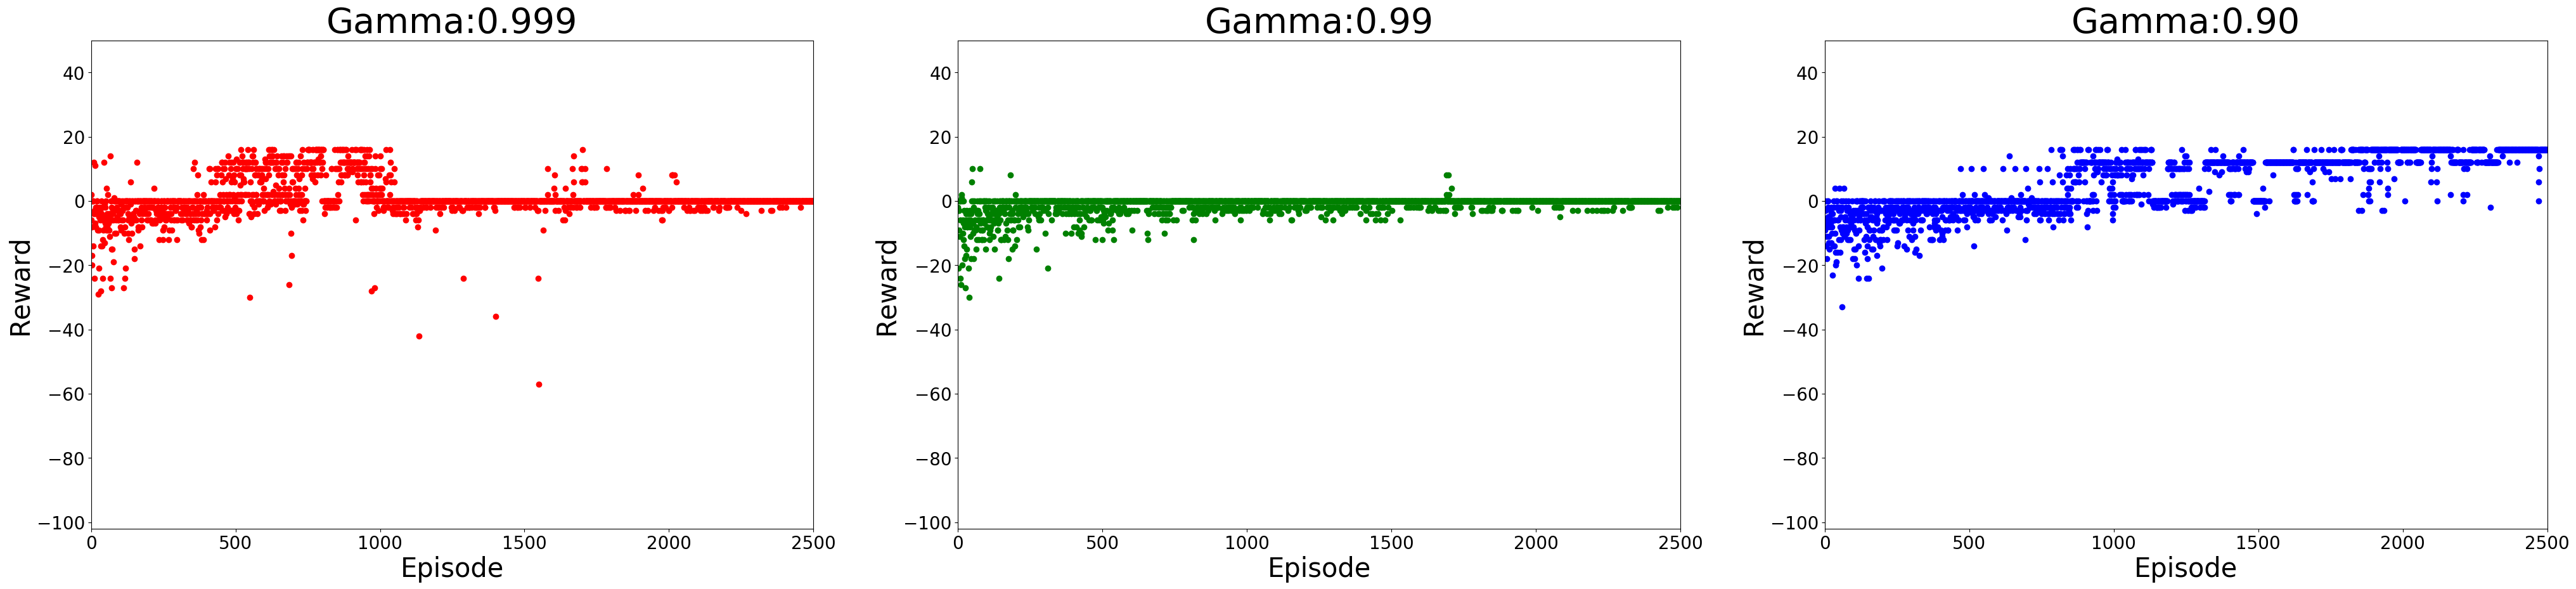

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(10)
fig.set_figwidth(50)
# fig.suptitle('Gamma Tuning', size="50")
ax1.plot(rewardSD_g1, 'ro')
ax1.set_title("Gamma:0.999", size=40)
ax1.set_ylabel('Reward', fontsize = 30) 
ax1.set_xlabel('Episode', fontsize = 30)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xlim(100)
ax1.set_xlim(xmin=0, xmax=len(rewardSD_g1))
ax1.set_ylim(ymin=-102, ymax=50)
ax2.plot(rewardSD_g2, 'go')
ax2.set_title("Gamma:0.99", size=40)
ax2.set_ylabel('Reward', fontsize = 30) 
ax2.set_xlabel('Episode', fontsize = 30)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(xmin=0, xmax=len(rewardSD_g2))
ax2.set_ylim(ymin=-102, ymax=50)
ax3.plot(rewardSD_g3, 'bo')
ax3.set_title("Gamma:0.90", size=40)
ax3.set_ylabel('Reward', fontsize = 30) 
ax3.set_xlabel('Episode', fontsize = 30)
ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)
ax3.set_xlim(xmin=0, xmax=len(rewardSD_g3))
ax3.set_ylim(ymin=-102, ymax=50)
plt.show()

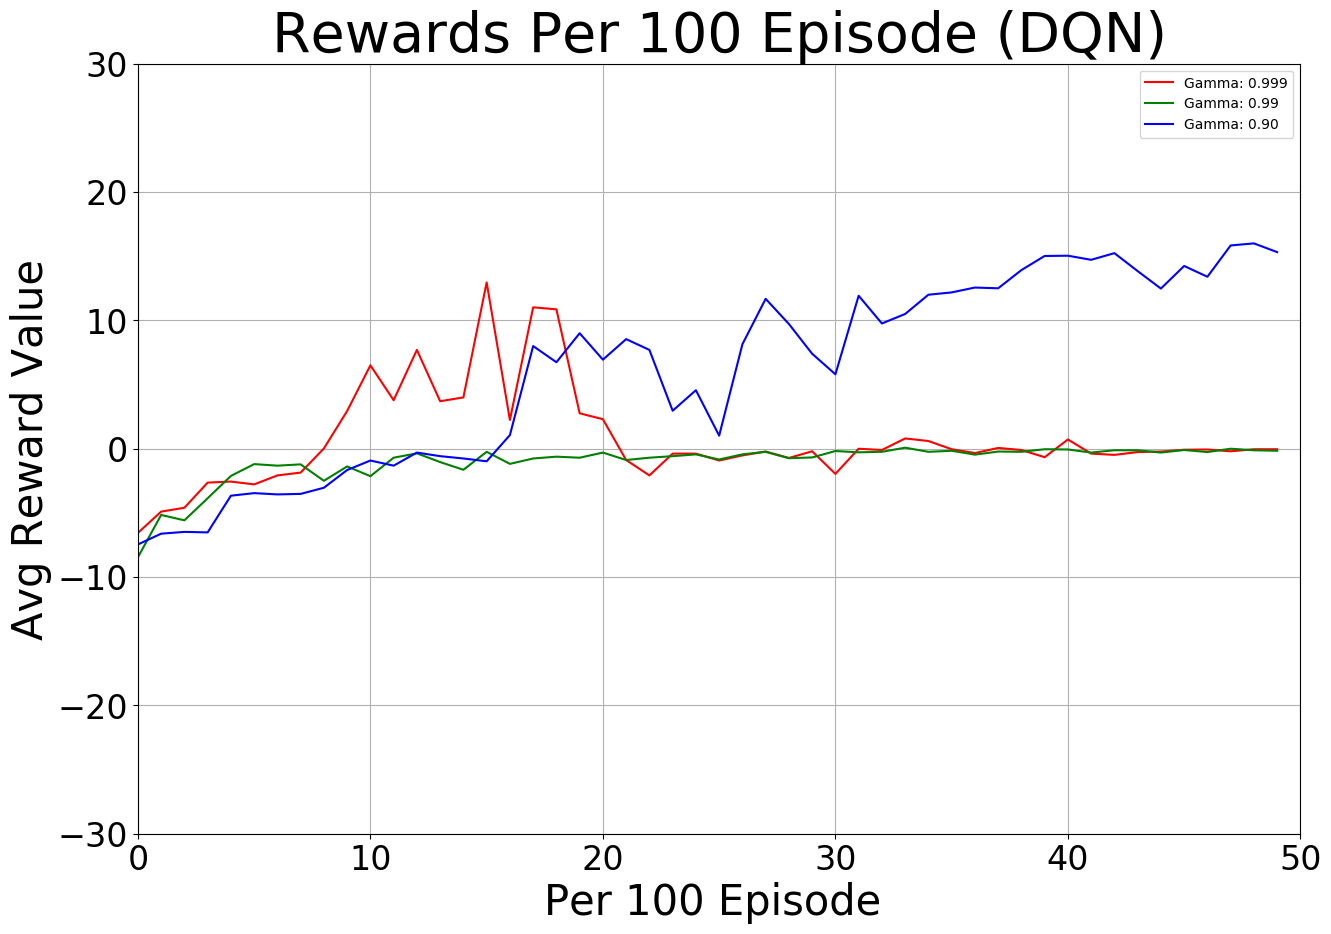

In [33]:
rewardQD_ts1_avg = []
rewardQD_ts2_avg = []
rewardQD_ts3_avg = []
for s in np.split(np.array(rewardSD_g1), 50):
    rewardQD_ts1_avg.append((sum(s)/len(s)))

for s in np.split(np.array(rewardSD_g2), 50):
    rewardQD_ts2_avg.append((sum(s)/len(s)))

for s in np.split(np.array(rewardSD_g3), 50):
    rewardQD_ts3_avg.append((sum(s)/len(s)))

plt.figure(figsize=(15, 10))
plt.plot(rewardQD_ts1_avg, 'r-')
plt.plot(rewardQD_ts2_avg, 'g-')
plt.plot(rewardQD_ts3_avg, 'b-')
plt.legend(["Gamma: 0.999", "Gamma: 0.99", "Gamma: 0.90"])
plt.xlabel('Per 100 Episode ', fontsize=30)
plt.ylabel('Avg Reward Value', fontsize=30)
plt.title('Rewards Per 100 Episode (DQN)', fontsize=40)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylim(ymin=-30, ymax=30)
plt.xlim(xmin=0, xmax=50)
plt.grid()
plt.show()

Training

In [7]:
env = MyMarioEnvironment2(environment_type = 'deterministic')
obs = env.reset()
a = GridVanillaDQN(env)
a.learn()

  4%|▍         | 101/2500 [00:13<05:17,  7.55episodes/s]

Buffer_size: 2960|Train_time:0.004011061191558838| Sub_t:0.004387373924255371
[Episode: 100] - Steps: 29.6 | Rewards: -5.42 | Epsilon: 0.8317637711026726 | loss: 0.871


  8%|▊         | 201/2500 [00:26<04:31,  8.47episodes/s]

Buffer_size: 3000|Train_time:0.003911552429199219| Sub_t:0.004317278861999512
[Episode: 200] - Steps: 28.97 | Rewards: -2.42 | Epsilon: 0.691830970918939 | loss: 2.770


 12%|█▏        | 301/2500 [00:39<04:50,  7.57episodes/s]

Buffer_size: 3000|Train_time:0.0042899250984191895| Sub_t:0.004741282463073731
[Episode: 300] - Steps: 26.19 | Rewards: 2.76 | Epsilon: 0.5754399373371608 | loss: 8.996


 16%|█▌        | 401/2500 [00:50<03:50,  9.11episodes/s]

Buffer_size: 3000|Train_time:0.0038436627388000488| Sub_t:0.004253537654876709
[Episode: 400] - Steps: 25.88 | Rewards: 3.93 | Epsilon: 0.47863009232264275 | loss: 2.353


 20%|██        | 502/2500 [01:00<02:39, 12.51episodes/s]

Buffer_size: 3000|Train_time:0.003772451877593994| Sub_t:0.004207906723022461
[Episode: 500] - Steps: 21.69 | Rewards: 8.55 | Epsilon: 0.3981071705535017 | loss: 4.008


 24%|██▍       | 601/2500 [01:11<04:17,  7.37episodes/s]

Buffer_size: 3000|Train_time:0.003963818550109863| Sub_t:0.004411070346832275
[Episode: 600] - Steps: 24.02 | Rewards: 5.78 | Epsilon: 0.3311311214825956 | loss: 8.580


 28%|██▊       | 701/2500 [01:22<03:04,  9.76episodes/s]

Buffer_size: 3000|Train_time:0.00383162260055542| Sub_t:0.004296426773071289
[Episode: 700] - Steps: 22.26 | Rewards: 8.27 | Epsilon: 0.27542287033382085 | loss: 6.178


 32%|███▏      | 800/2500 [01:33<02:43, 10.42episodes/s]

Buffer_size: 3000|Train_time:0.0037384700775146486| Sub_t:0.004207608699798584
[Episode: 800] - Steps: 23.86 | Rewards: 6.68 | Epsilon: 0.22908676527678132 | loss: 5.044


 36%|███▌      | 901/2500 [01:40<01:43, 15.38episodes/s]

Buffer_size: 3000|Train_time:0.003799436092376709| Sub_t:0.004251549243927002
[Episode: 900] - Steps: 16.28 | Rewards: 12.54 | Epsilon: 0.19054607179632832 | loss: 2.269


 40%|████      | 1001/2500 [01:48<02:14, 11.11episodes/s]

Buffer_size: 3000|Train_time:0.003726673126220703| Sub_t:0.00418853759765625
[Episode: 1000] - Steps: 17.67 | Rewards: 9.61 | Epsilon: 0.15848931924611465 | loss: 4.138


 44%|████▍     | 1102/2500 [01:55<01:18, 17.85episodes/s]

Buffer_size: 3000|Train_time:0.004705605506896973| Sub_t:0.005290853977203369
[Episode: 1100] - Steps: 16.67 | Rewards: 10.82 | Epsilon: 0.13182567385564378 | loss: 4.581


 48%|████▊     | 1204/2500 [02:01<01:11, 18.24episodes/s]

Buffer_size: 3000|Train_time:0.003785991668701172| Sub_t:0.004307537078857422
[Episode: 1200] - Steps: 12.74 | Rewards: 13.38 | Epsilon: 0.10964781961432139 | loss: 2.788


 52%|█████▏    | 1304/2500 [02:07<01:09, 17.21episodes/s]

Buffer_size: 3000|Train_time:0.004545838832855225| Sub_t:0.005180881023406982
[Episode: 1300] - Steps: 12.22 | Rewards: 12.96 | Epsilon: 0.09120108393559365 | loss: 6.907


 56%|█████▌    | 1400/2500 [02:13<00:50, 21.60episodes/s]

Buffer_size: 3000|Train_time:0.003607316017150879| Sub_t:0.004076175689697266
[Episode: 1400] - Steps: 11.73 | Rewards: 13.0 | Epsilon: 0.07585775750292077 | loss: 3.995


 60%|██████    | 1501/2500 [02:19<01:01, 16.13episodes/s]

Buffer_size: 3000|Train_time:0.003743042945861816| Sub_t:0.004253535270690918
[Episode: 1500] - Steps: 14.84 | Rewards: 10.61 | Epsilon: 0.06309573444802141 | loss: 3.586


 64%|██████▍   | 1603/2500 [02:26<00:46, 19.10episodes/s]

Buffer_size: 3000|Train_time:0.00407179594039917| Sub_t:0.004605202674865722
[Episode: 1600] - Steps: 15.02 | Rewards: 12.35 | Epsilon: 0.052480746024979104 | loss: 5.299


 68%|██████▊   | 1703/2500 [02:32<00:35, 22.61episodes/s]

Buffer_size: 3000|Train_time:0.003592720031738281| Sub_t:0.004116883277893066
[Episode: 1700] - Steps: 12.25 | Rewards: 13.1 | Epsilon: 0.043651583224018214 | loss: 1.477


 72%|███████▏  | 1803/2500 [02:37<00:31, 22.47episodes/s]

Buffer_size: 3000|Train_time:0.0037478208541870117| Sub_t:0.0042481827735900875
[Episode: 1800] - Steps: 10.81 | Rewards: 14.66 | Epsilon: 0.03630780547701154 | loss: 1.938


 76%|███████▌  | 1903/2500 [02:42<00:25, 23.06episodes/s]

Buffer_size: 3000|Train_time:0.003646426200866699| Sub_t:0.004189753532409668
[Episode: 1900] - Steps: 11.83 | Rewards: 13.68 | Epsilon: 0.030199517204021385 | loss: 1.033


 80%|████████  | 2004/2500 [02:47<00:22, 22.11episodes/s]

Buffer_size: 3000|Train_time:0.003598020076751709| Sub_t:0.004111330509185791
[Episode: 2000] - Steps: 11.55 | Rewards: 11.38 | Epsilon: 0.025118864315096866 | loss: 4.826


 84%|████████▍ | 2102/2500 [02:52<00:18, 21.14episodes/s]

Buffer_size: 3000|Train_time:0.0036009430885314943| Sub_t:0.0040604138374328615
[Episode: 2100] - Steps: 11.03 | Rewards: 14.18 | Epsilon: 0.02089296130854132 | loss: 1.158


 88%|████████▊ | 2204/2500 [02:56<00:12, 22.90episodes/s]

Buffer_size: 3000|Train_time:0.003634600639343262| Sub_t:0.004165811538696289
[Episode: 2200] - Steps: 10.46 | Rewards: 15.74 | Epsilon: 0.017378008287494567 | loss: 0.478


 92%|█████████▏| 2302/2500 [03:01<00:08, 23.59episodes/s]

Buffer_size: 3000|Train_time:0.00361558198928833| Sub_t:0.0041291570663452145
[Episode: 2300] - Steps: 10.76 | Rewards: 14.26 | Epsilon: 0.014454397707459973 | loss: 2.542


 96%|█████████▌| 2404/2500 [03:05<00:04, 23.56episodes/s]

Buffer_size: 3000|Train_time:0.0035668325424194334| Sub_t:0.004100322723388672
[Episode: 2400] - Steps: 10.16 | Rewards: 15.95 | Epsilon: 0.012022644346174735 | loss: 0.134


100%|██████████| 2500/2500 [03:10<00:00, 13.14episodes/s]

Buffer_size: 3000|Train_time:0.0036126351356506347| Sub_t:0.004095451831817627
[Episode: 2500] - Steps: 10.35 | Rewards: 14.97 | Epsilon: 0.01000000000000053 | loss: 0.753


In [8]:
epsilon_list_train_dqn = a.epsilon_list
reward_list_train_dqn = a.rewards_list

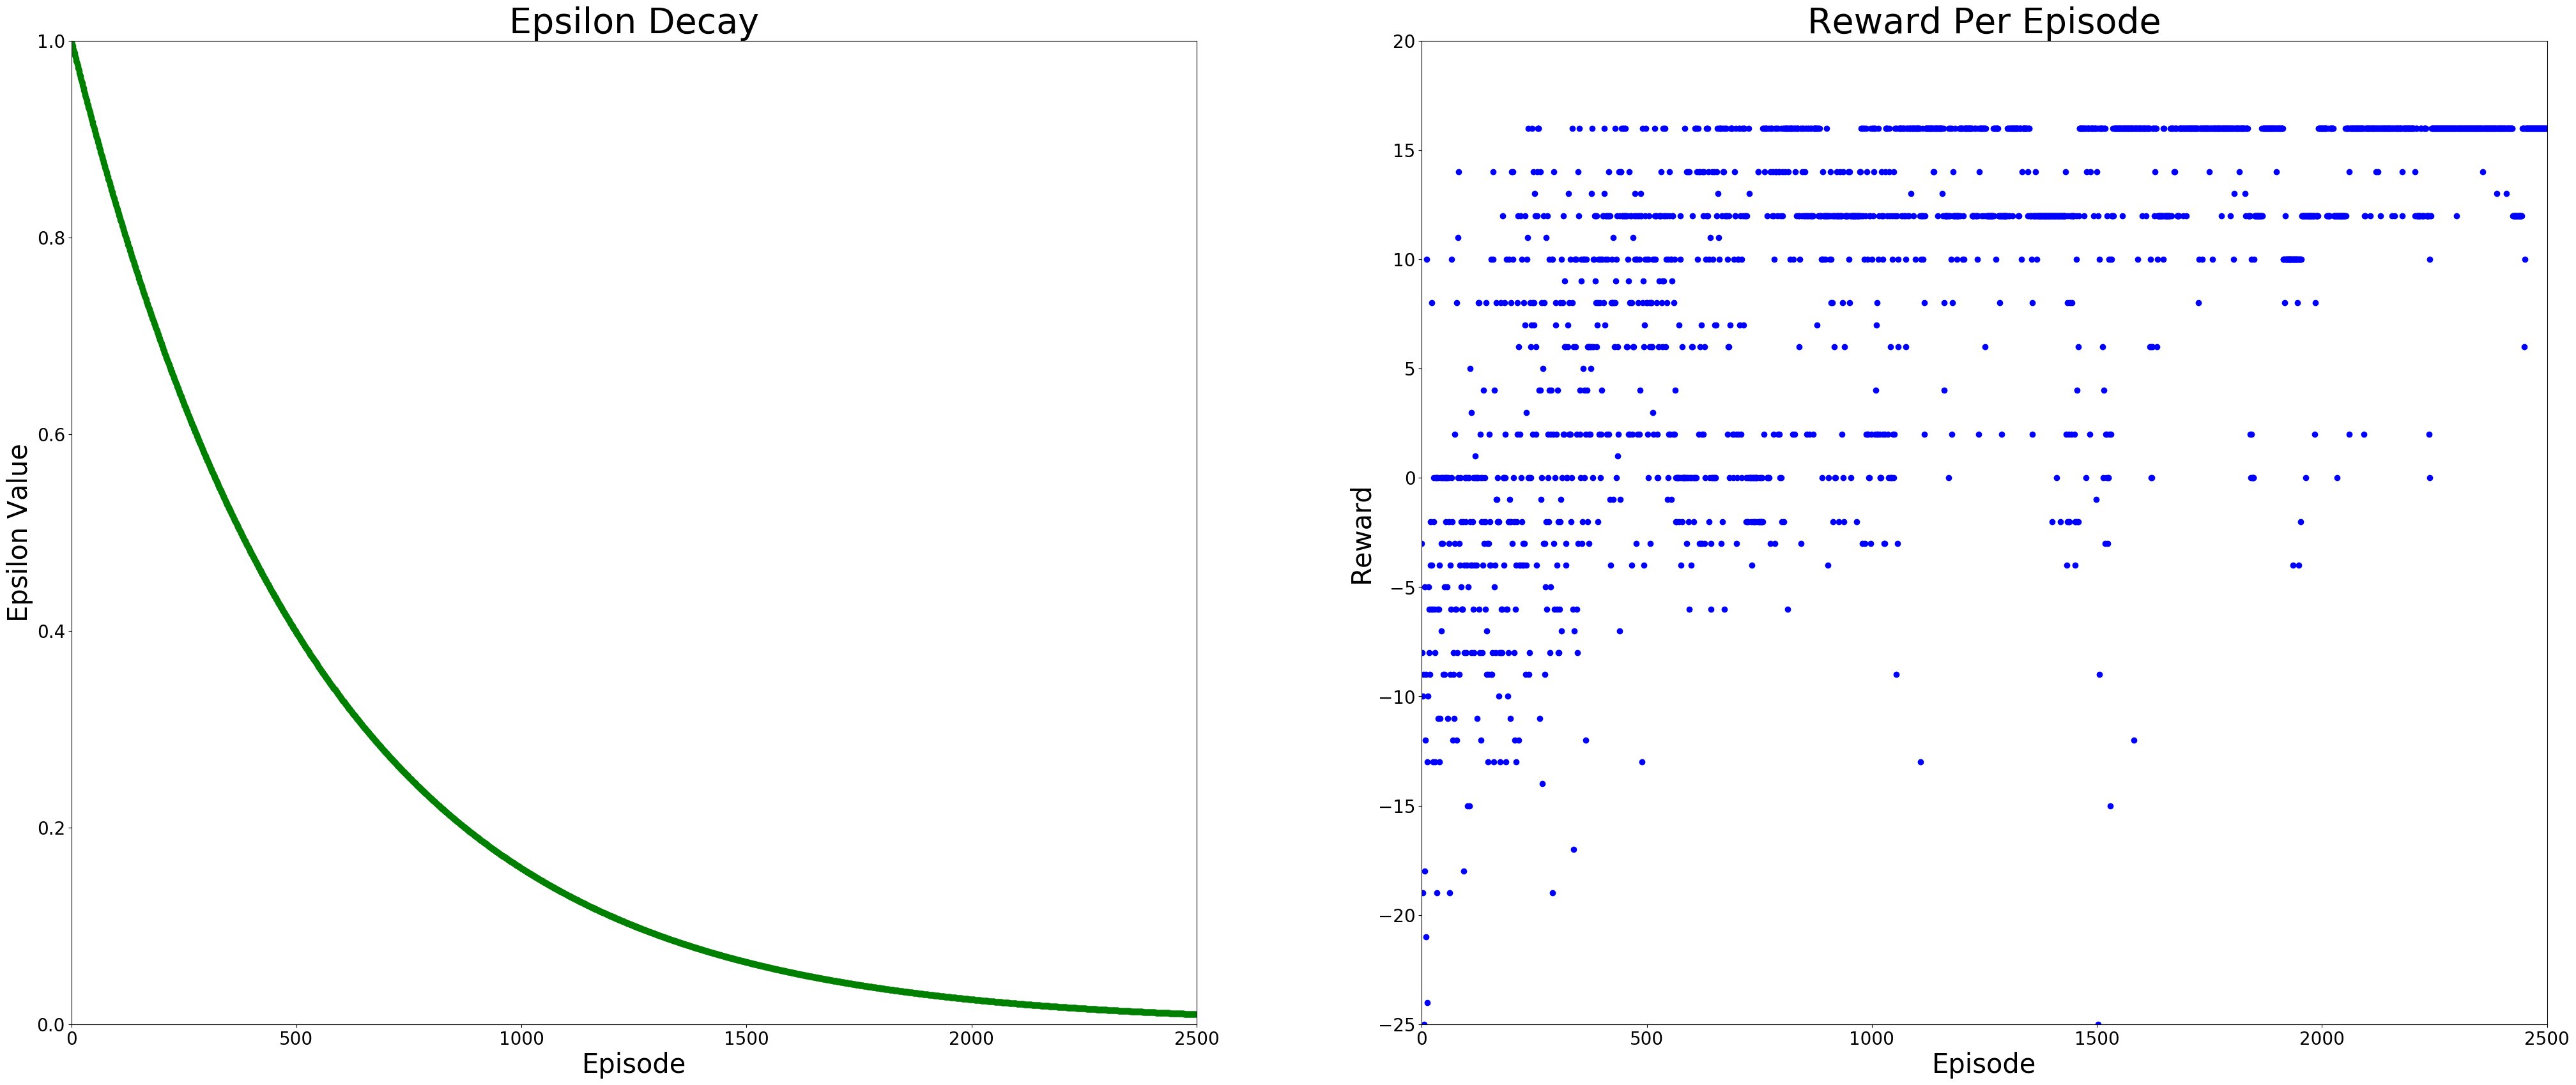

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(20)
fig.set_figwidth(50)
# fig.suptitle('Gamma Tuning', size="50")
ax1.plot(epsilon_list_train_dqn, 'go')
ax1.set_title("Epsilon Decay", size=40)
ax1.set_ylabel('Epsilon Value', fontsize = 30) 
ax1.set_xlabel('Episode', fontsize = 30)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xlim(100)
ax1.set_xlim(xmin=0, xmax=a.max_episodes)
ax1.set_ylim(ymin=0, ymax=1)
ax2.plot(reward_list_train_dqn, 'bo')
ax2.set_title(f"Reward Per Episode", size=40)
ax2.set_ylabel('Reward', fontsize = 30) 
ax2.set_xlabel('Episode', fontsize = 30)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(xmin=0, xmax=a.max_episodes)
ax2.set_ylim(ymin=-25, ymax=20)
plt.show()

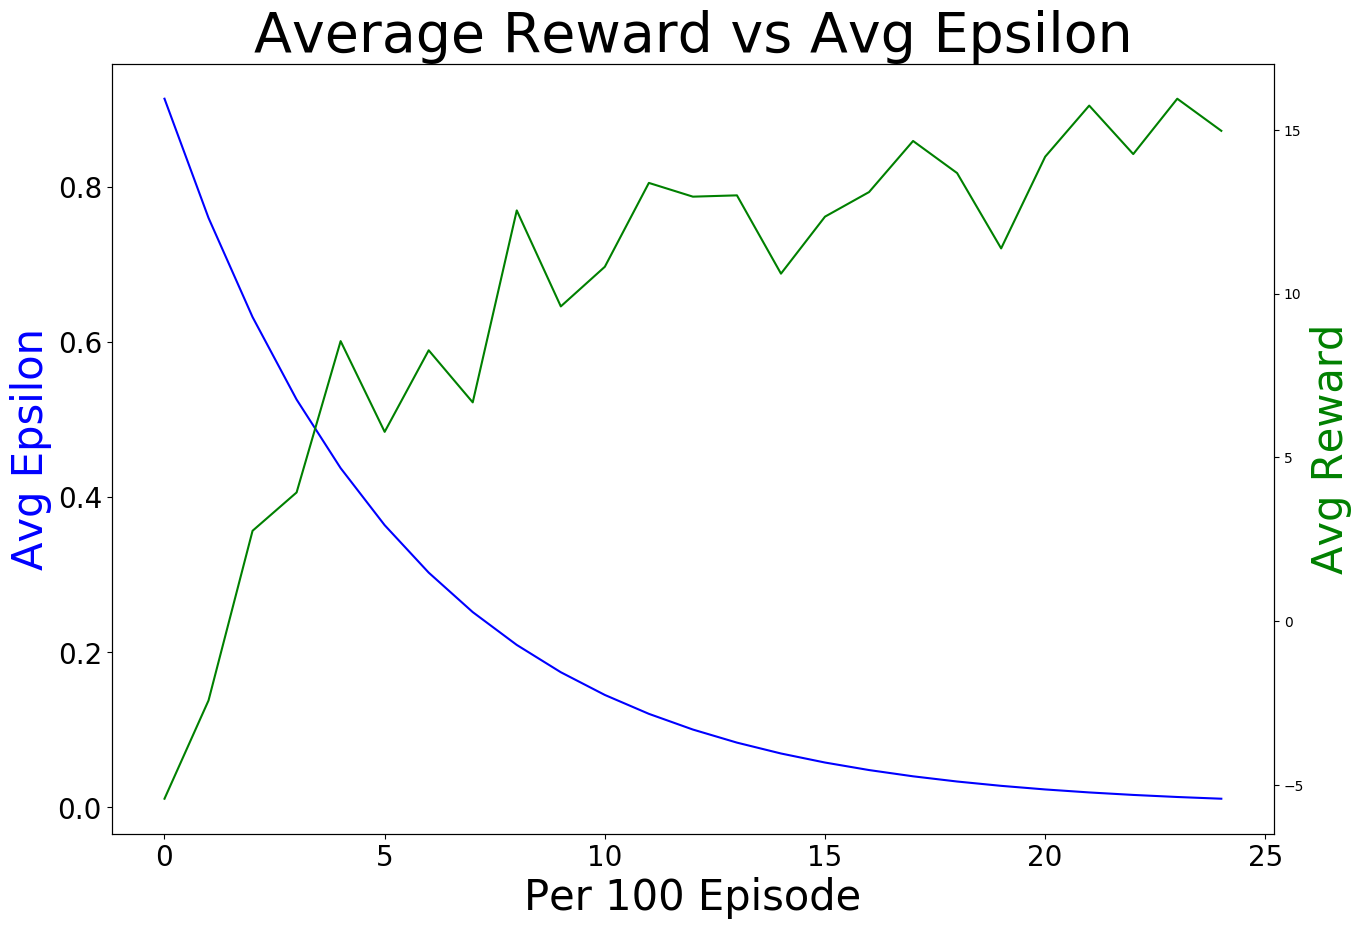

In [10]:
rewardSD_train_dqn_avg = []
for s in np.split(np.array(reward_list_train_dqn), 25):
    rewardSD_train_dqn_avg.append((sum(s)/len(s)))
    
epsilonSD_train_dqn_avg = []
for s in np.split(np.array(epsilon_list_train_dqn), 25):
    epsilonSD_train_dqn_avg.append((sum(s)/len(s)))

fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
plt.tick_params(axis='both', which='major', labelsize=20)
ax2 = ax1.twinx()
ax1.plot(epsilonSD_train_dqn_avg, 'b-')
ax2.plot(rewardSD_train_dqn_avg, 'g-')
ax1.set_title("Average Reward vs Avg Epsilon", size=40)
ax1.set_xlabel('Per 100 Episode', fontsize=30)
ax1.set_ylabel('Avg Epsilon', color='b', fontsize=30)
ax2.set_ylabel('Avg Reward', color='g', fontsize=30)
plt.show()

In [15]:
import json
with open('reward_dqn.json', 'w') as f:
    json.dump(reward_list_train_dqn, f)

In [17]:
import json
with open('reward_dqn.json') as f:
    reward_list_train_dqn = json.load(f)

In [11]:
PATH = './grid.pth'
torch.save(a.q_value_dqn.state_dict(), PATH)

In [20]:
env = MyMarioEnvironment2(environment_type = 'deterministic')
env.reset()
a = GridVanillaDQN(env)
a.eval(load=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
100%|██████████| 10/10 [00:00<00:00, 122.96episodes/s]


In [21]:
reward_list_test_dqn = a.test_rewards_list

<Figure size 640x480 with 0 Axes>

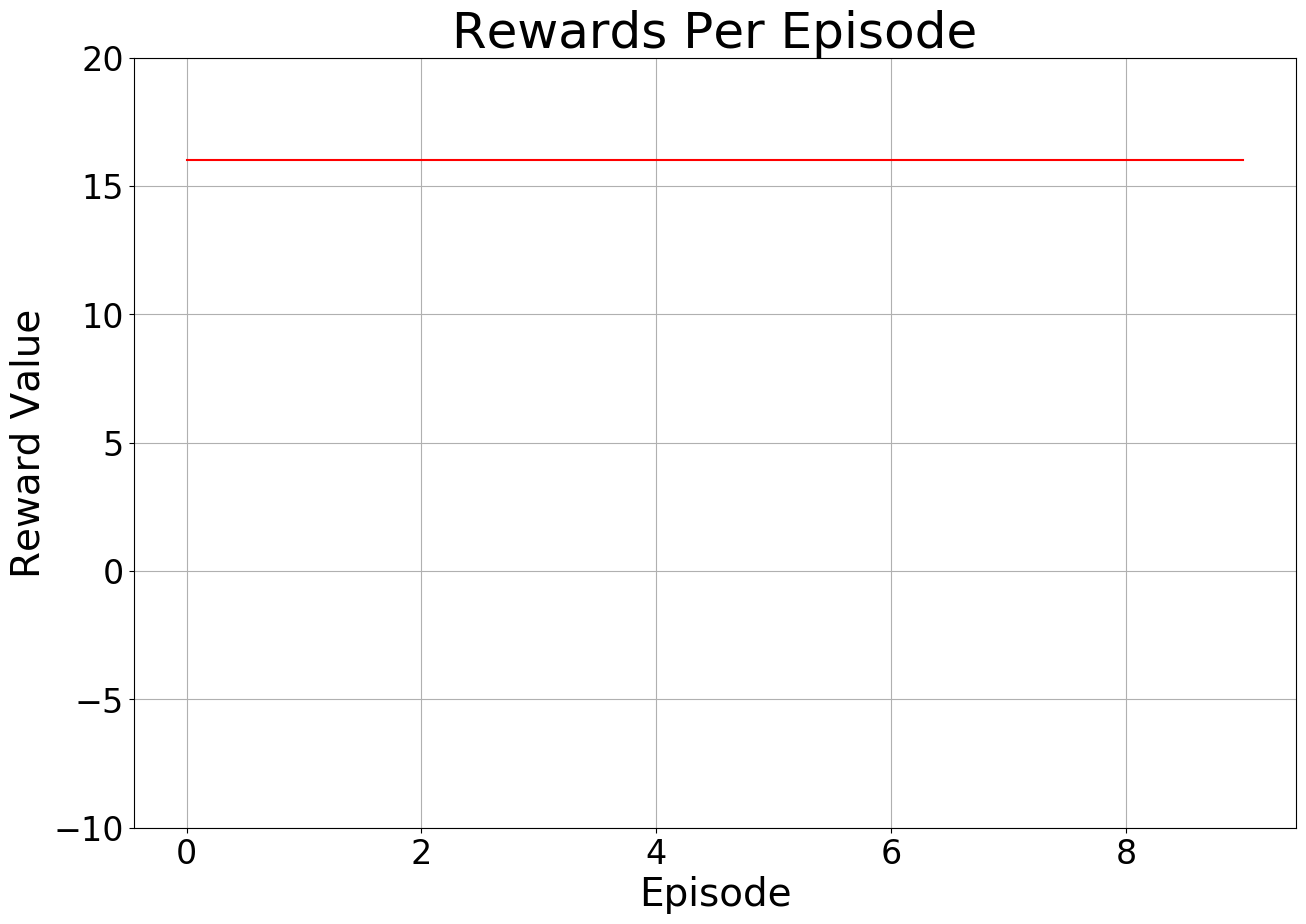

In [22]:
plt.clf()
plt.figure(figsize=(15, 10))
plt.plot(reward_list_test_dqn, 'r-')
plt.xlabel('Episode', fontsize=28)
plt.ylabel('Reward Value', fontsize=28)
plt.title(f'Rewards Per Episode', fontsize=36)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# plt.yticks([-100, -50, 0, 10, 20], fontsize=24)
plt.ylim(ymin=-10, ymax=20)
# plt.xlim(xmin=0, xmax=self.max_episodes_test)
plt.grid()
plt.show()